In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.applications.vgg16 import VGG16
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.layers import Flatten, Dense
from keras.models import Sequential
from keras.optimizers import Adam

# Модель-1

In [ ]:
# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print("x_train original shape", x_train.shape)
print("y_train original shape", y_train.shape)
print("x_test original shape", x_test.shape)
print("y_test original shape", y_test.shape)

x_train original shape (60000, 28, 28)
y_train original shape (60000,)
x_test original shape (10000, 28, 28)
y_test original shape (10000,)


In [ ]:
# Змінюємо розмір зображень на 32*32 відповідно до вимог VGG16
x_train = tf.image.resize(np.array(x_train)[..., tf.newaxis], (32, 32))
x_train = np.repeat(x_train, 3, axis=-1)
x_test = tf.image.resize(np.array(x_test)[..., tf.newaxis], (32, 32))
x_test = np.repeat(x_test, 3, axis=-1)

# Змінюємо значення пікселів з (0, 255) до (0, 1)
x_train = np.array(x_train) / 255.0
x_test = np.array(x_test) / 255.0

In [ ]:
# перевіряємо оновлений розмір датасету
x_train.shape, x_test.shape

((60000, 32, 32, 3), (10000, 32, 32, 3))

In [ ]:
# Конвертація Labels в інший формат (one hot encoded)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [ ]:
# Створюємо основу згортки на базі VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
# Відключємо навчання шару
conv_base.trainable = False

In [ ]:
# Створюємо згорткову нейромережу, що використовує VGG16 як згортковий шар
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(10, activation="softmax"))

In [ ]:
# Компілюємо модель (підгонка терезів нейромережі)
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

In [ ]:
# дізнаємося архітектуру створеної НМ
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 10)                2570      
                                                                 
Total params: 14848586 (56.64 MB)
Trainable params: 133898 (523.04 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
# навчання нейронної мережі
history = model.fit(x_train,
                    y_train,
                    epochs=10,
                    verbose=1,
                    batch_size=64,
                    validation_split=0.2
                    )

Epoch 1/10
750/750 [==============================] - 12s 14ms/step - loss: 0.5670 - accuracy: 0.8001 - val_loss: 0.4524 - val_accuracy: 0.8350
Epoch 2/10
750/750 [==============================] - 10s 13ms/step - loss: 0.4172 - accuracy: 0.8483 - val_loss: 0.4223 - val_accuracy: 0.8456
Epoch 3/10
750/750 [==============================] - 11s 15ms/step - loss: 0.3821 - accuracy: 0.8583 - val_loss: 0.3953 - val_accuracy: 0.8549
Epoch 4/10
750/750 [==============================] - 10s 14ms/step - loss: 0.3589 - accuracy: 0.8688 - val_loss: 0.3898 - val_accuracy: 0.8574
Epoch 5/10
750/750 [==============================] - 10s 13ms/step - loss: 0.3424 - accuracy: 0.8733 - val_loss: 0.3760 - val_accuracy: 0.8637
Epoch 6/10
750/750 [==============================] - 9s 13ms/step - loss: 0.3279 - accuracy: 0.8791 - val_loss: 0.3780 - val_accuracy: 0.8621
Epoch 7/10
750/750 [==============================] - 10s 14ms/step - loss: 0.3138 - accuracy: 0.8837 - val_loss: 0.3707 - val_accuracy: 

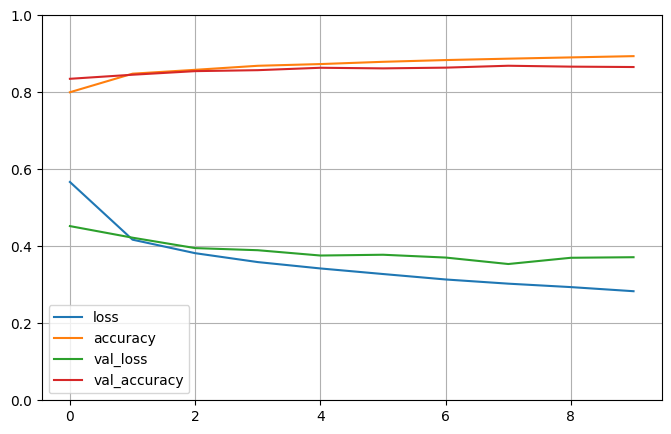

In [ ]:
# виведемо графік втрат і точності
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
# Оцінка якості моделі-1
result = model.evaluate(x_test, y_test)
print(f'відсоток вірних відповідей - {round(result[1] * 100, 1)}%')

313/313 [==============================] - 3s 8ms/step - loss: 0.3860 - accuracy: 0.8653
відсоток вірних відповідей - 86.5%


In [ ]:
# Виводимо архітектуру нашої згортної основи
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
# Зробимо донавчання останніх трьох шарів
for i, layer in enumerate(model.layers):
    layer._name = 'layer_' + str(i)


# conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


modified_model = Sequential([
   conv_base,
   Flatten(),
   Dense(256, activation="relu"),
   Dense(10, activation="softmax"),
])

In [ ]:
# Компілюємо модель
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

In [ ]:
# навчання нейронної мережі
history_modified = model.fit(
    x_train,
    y_train,
    epochs=5,
    verbose=1,
    batch_size=64,
    validation_split=0.2
)

Epoch 1/5
750/750 [==============================] - 18s 21ms/step - loss: 0.3808 - accuracy: 0.8603 - val_loss: 0.3373 - val_accuracy: 0.8736
Epoch 2/5
750/750 [==============================] - 16s 21ms/step - loss: 0.2857 - accuracy: 0.8947 - val_loss: 0.2972 - val_accuracy: 0.8928
Epoch 3/5
750/750 [==============================] - 15s 21ms/step - loss: 0.2479 - accuracy: 0.9074 - val_loss: 0.2894 - val_accuracy: 0.8971
Epoch 4/5
750/750 [==============================] - 16s 21ms/step - loss: 0.2261 - accuracy: 0.9156 - val_loss: 0.2871 - val_accuracy: 0.8963
Epoch 5/5
750/750 [==============================] - 16s 21ms/step - loss: 0.2046 - accuracy: 0.9230 - val_loss: 0.2887 - val_accuracy: 0.8978


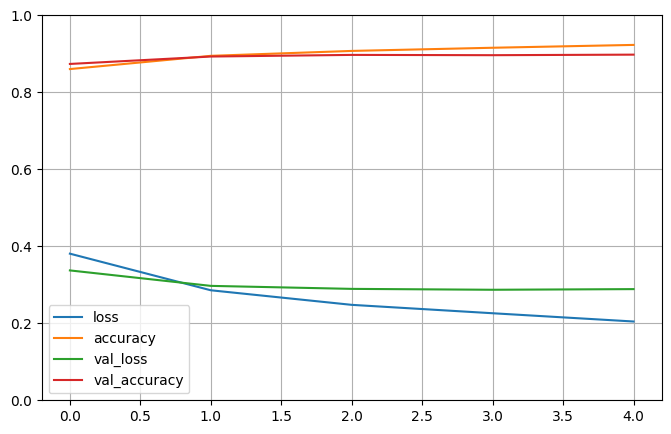

In [ ]:
# виведемо графік втрат і точності
pd.DataFrame(history_modified.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
# Оцінка якості донавченої моделі-1
result_modified = model.evaluate(x_test, y_test)
print(f'відсоток вірних відповідей - {round(result_modified[1] * 100, 1)}%')

313/313 [==============================] - 3s 8ms/step - loss: 0.3092 - accuracy: 0.8963
відсоток вірних відповідей - 89.6%


Висновок: порівнюючи звичайну згорткову мережу та згорткову мережу, що використовує VGG16 в якості згорткової основи, можемо помітити, що звичайна згортоква мережа показала вищу точність. Навіть з донавчанням трьох останніх шарів в 5 епох, дана створена модель не змогла показати точності звичайної згорткової мережі в 91% якого досягли у моделі-2 в ДЗ-10-1.